<a href="https://colab.research.google.com/github/TarunReddy77/LLaMA_Finetuning/blob/main/LLaMA_3_2_1B_Instruct_Finetuning_on_the_IMBD_dataset_using_qlora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-Tuning Llama 3.2 1B for Sentiment Analysis**

### **Objective:**
This notebook documents a robust, end-to-end workflow for fine-tuning the `meta-llama/Llama-3.2-1B-Instruct` model on the IMDB Movie Reviews dataset. The primary goal is to demonstrate a professional methodology that balances performance with computational efficiency, rather than solely pursuing state-of-the-art metrics.

---

### **Workflow at a Glance:**

Our pipeline is structured to be reproducible, resource-aware, and methodologically sound.

* 🧹 **Data Integrity First:** We begin with a rigorous data cleaning and de-duplication phase to ensure the quality of our training data and prevent data leakage between splits.

* 📊 **Data-Driven Preprocessing:** We perform a token-level distribution analysis to make a justified, hardware-aware decision for our model's `max_length`. We then employ a stratified sampling strategy to create perfectly balanced train, validation, and test sets.

* 🎯 **Zero-Shot Baseline:** Before fine-tuning, we establish a quantitative baseline by evaluating the base model's zero-shot performance on the task. This allows us to precisely measure the value added by our adaptation.

* 🛠️ **Efficient Fine-Tuning (QLoRA):** We use Quantized Low-Rank Adaptation (QLoRA) to efficiently fine-tune the model on a single T4 GPU, training only ~0.14% of the total parameters.

* 🤖 **Automated & Resilient Training:** The training process is automated with learning rate scheduling, frequent checkpointing to Google Drive, and early stopping based on validation loss to prevent overfitting and conserve compute.

* 📈 **Comprehensive Evaluation:** We conclude with a detailed evaluation of the best model checkpoint, analyzing not just the final metrics but also the training dynamics and error patterns via a confusion matrix.

## **Section 1. Environment Setup**

PLEASE CONNECT TO GPU RUNTIME BEFORE YOU PROCEED FURTHER

### **Installations**

To ensure reproducibility and compatibility with the `meta-llama/Llama-3.2-1B-Instruct` model, we begin by upgrading the core Hugging Face libraries (`transformers`, `datasets`, `peft`, `accelerate`) and other essential packages to their latest versions. This step mitigates potential version-related conflicts within the Colab environment.

In [1]:
print("⏳ Upgrading required libraries...")
!pip install -U -q transformers datasets peft accelerate bitsandbytes matplotlib scikit-learn wordcloud
print("✅ Libraries upgraded successfully.")

⏳ Upgrading required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━

### **Imports, Authentication, and Global Configuration**

This cell handles the initial setup for the notebook. We import all necessary libraries, define global configuration variables like the `MODEL_NAME` for easy maintenance, and handle authentication.

**First-Time Setup Instructions:**
* **Hugging Face Token:** To access the gated Llama 3.2 model, you must provide a Hugging Face access token.
    1.  Click the "🔑" icon in the left sidebar of Colab to open the **Secrets** manager.
    2.  Create a new secret with the name `HF_TOKEN`.
    3.  Paste your Hugging Face token (with at least "read" permissions) as the value.
    4.  Ensure the "Notebook access" toggle is enabled.
    5.  **Note:** The LLaMA 3.2 model is hosted in a gated repository on Hugging Face. You must request and receive access to the model before you can use it.

* **Google Drive:** When the cell is run, you will be prompted to authorize access to your Google Drive. This is required for saving model checkpoints persistently.

In [2]:
# --- 2.1: Library Imports ---

# Standard Python Libraries
import json
import os
import random
import re
from glob import glob
from textwrap import fill

# Third-party Libraries for Data Handling and Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display

# Scikit-learn for metrics and feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, f1_score, precision_score, recall_score
)

# Hugging Face Libraries
from datasets import Dataset, DatasetDict, concatenate_datasets, load_dataset
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training, TaskType
from transformers import (
    AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer,
    BitsAndBytesConfig, DataCollatorWithPadding, EarlyStoppingCallback,
    Trainer, TrainingArguments
)
from tqdm.auto import tqdm

# Colab-specific Libraries
from google.colab import drive, userdata

# --- 2.2: Hugging Face Authentication ---
# We securely load the Hugging Face token from Colab's secrets manager.
# This is the recommended practice to avoid exposing sensitive keys in the notebook.
try:
    os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
    print("✅ Hugging Face token loaded successfully from Colab secrets.")
except Exception as e:
    print("⚠️ Could not load Hugging Face token. Please ensure it is stored as a secret named 'HF_TOKEN'.")
    print("Falling back to notebook_login()...")
    from huggingface_hub import notebook_login
    notebook_login()


# --- 2.3: Global Configuration ---
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# Mount Google Drive to save model checkpoints persistently.
try:
    drive.mount('/content/drive')
    print("✅ Google Drive mounted successfully.")
except Exception as e:
    print(f"⚠️ Could not mount Google Drive. Checkpoints will be saved locally. Error: {e}")

✅ Hugging Face token loaded successfully from Colab secrets.
Mounted at /content/drive
✅ Google Drive mounted successfully.


## **Section 2: Exploratory Data Analysis and Data Preprocessing**

Before proceeding to the modeling phase, a thorough Exploratory Data Analysis is essential to understand the dataset's structure, quality, and underlying patterns. This analysis will directly inform our data preprocessing and modeling strategies.

Our EDA will cover five key steps:



1.  **Data Loading & Initial Inspection:** Loading the dataset into a pandas DataFrame for easier manipulation.
2.  **Data Cleaning:** Identifying and removing artifacts like HTML tags that could negatively impact model performance.
3.  **Token Length Distribution:** Analyzing the length of reviews in tokens to make a data-driven decision for the `max_length` hyperparameter.
4.  **Class Balance:** Checking the distribution of positive and negative labels to ensure the dataset is balanced and our evaluation metrics will be meaningful.
5.  **N-gram and Word Cloud Analysis:** Visualizing the most common words and phrases to get a qualitative feel for the language associated with each sentiment.

#### Load Dataset

In [3]:
dataset = load_dataset("imdb")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
#@title Bug Fix

# UNCOMMENT the below code and run this cell ONLY if the dataset in the above cell cannot be loaded due to corruption in Colab cache (You will see an error).

# !rm -rf ~/.cache/huggingface/datasets
# !rm -rf ~/.cache/huggingface/hub

# !pip install -U datasets -q

# RESTART THE SESSION - DO NOT INSTALL PACKAGES OR LIBRARIES AFTER RESTART

Let us have a look at a sample review from the dataset

In [5]:
train_df.sample(1)['text'].values[0]

"** HERE BE SPOILERS **<br /><br />The government has continued to develop the UniversalSoldier program, now called UniSol. The soldiers are now stronger and are able to take more damage than before. However the government is downsizing, the project endangered and the supercomputer that is in the middle of all feel threatened, so he takes steps to ensure his own safety. He activates and controls the UniSols and start to run mayhem. The only one who can stop them is Deveraux (Van Damme). <br /><br />This movie is about one thing. Choreographed fighting. The story is bad, and is soon drowned in all fights. Whatever happens, and wherever they go, they fight. Unfortunately for this movie, it is no fun watching a fight where you know one part of it is indestructible. Normally you're pretty sure the hero will win, but you still want to feel the fights are between two somewhat equal combatants. Not where one is indestructible and can't lose. Then the fights just become a tool to stretch time.

We see that the review contains html tags which are useless and  could be potentially misleading for our model to predict the correct sentiment. So, let us remove them using a simple regex function.

#### Removing HTML Tags

In [6]:
def clean_html(text):
    """Removes all HTML tags from text using a regular expression."""
    return re.sub(r'<.*?>', ' ', text)

print("Cleaning HTML tags from the dataset...")

train_df['text'] = train_df['text'].apply(clean_html)
test_df['text'] = test_df['text'].apply(clean_html)

print("✅ Cleaning complete.")

Cleaning HTML tags from the dataset...
✅ Cleaning complete.


### **Data Cleaning and De-duplication**

The foundation of any reliable machine learning model is high-quality data. Raw datasets, especially those scraped from the web, often contain artifacts and inconsistencies that can degrade model performance and lead to misleading evaluation results. This section details the rigorous cleaning and de-duplication pipeline we implemented to ensure the integrity of our dataset.

**Methodology:**
1.  **Initial Quality Checks:** We first scan for and remove any `NaN` values or empty strings. This step prevents errors in the tokenization pipeline and ensures that every sample contains meaningful text.
2.  **Intra-Set De-duplication:** We identify and remove any exact duplicate reviews *within* the training set and, separately, *within* the test set.
3.  **Inter-Set De-duplication (Preventing Data Leakage):** This is the most critical cleaning step. We check for any reviews that exist in both the training and test sets. These are removed from the test set to guarantee that our final evaluation is performed on truly unseen data, providing an unbiased measure of the model's generalization ability.

In [7]:
print("--- Starting Data De-duplication ---")

print(f"Original training set size: {len(train_df)}")
print(f"Original test set size: {len(test_df)}")

# --- Identify and remove duplicates within each set ---
num_train_duplicates = train_df.duplicated(subset=['text']).sum()
num_test_duplicates = test_df.duplicated(subset=['text']).sum()

print(f"\nFound {num_train_duplicates} duplicates in the training set.")
print(f"Found {num_test_duplicates} duplicates in the test set.")

train_df.drop_duplicates(subset=['text'], inplace=True, keep='first')
test_df.drop_duplicates(subset=['text'], inplace=True, keep='first')

print(f"\nSize of training set after internal de-duplication: {len(train_df)}")
print(f"Size of test set after internal de-duplication: {len(test_df)}")

# --- Identify and remove duplicates across train and test sets ---
# This is the most critical step to prevent data leakage
train_texts = set(train_df['text'])
test_in_train_mask = test_df['text'].isin(train_texts)
num_cross_duplicates = test_in_train_mask.sum()

print(f"\nFound {num_cross_duplicates} reviews in the test set that are also present in the training set.")

# Remove these cross-set duplicates from the test set
test_df = test_df[~test_in_train_mask].copy()

print(f"\nFinal size of test set after all de-duplication: {len(test_df)}")

# Check for and remove any missing values (NaNs)
print(f"\nMissing values in train set: {train_df['text'].isnull().sum()}")
print(f"Missing values in test set: {test_df['text'].isnull().sum()}")
train_df.dropna(subset=['text'], inplace=True)
test_df.dropna(subset=['text'], inplace=True)

# Check for and remove any empty strings that resulted from cleaning
train_df['is_empty'] = train_df['text'].str.strip().eq('')
test_df['is_empty'] = test_df['text'].str.strip().eq('')
print(f"\nEmpty strings in train set after cleaning: {train_df['is_empty'].sum()}")
print(f"Empty strings in test set after cleaning: {test_df['is_empty'].sum()}")
train_df = train_df[~train_df['is_empty']]
test_df = test_df[~test_df['is_empty']]

print(f"\nFinal size of train set after all cleaning: {len(train_df)}")
print(f"\nFinal size of test set after all cleaning: {len(test_df)}")

# --- Convert cleaned pandas DataFrames back to Hugging Face Datasets ---
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df)
})

print("\n--- ✅ De-duplication Complete. Using cleaned dataset for all further steps. ---")

--- Starting Data De-duplication ---
Original training set size: 25000
Original test set size: 25000

Found 96 duplicates in the training set.
Found 199 duplicates in the test set.

Size of training set after internal de-duplication: 24904
Size of test set after internal de-duplication: 24801

Found 123 reviews in the test set that are also present in the training set.

Final size of test set after all de-duplication: 24678

Missing values in train set: 0
Missing values in test set: 0

Empty strings in train set after cleaning: 0
Empty strings in test set after cleaning: 0

Final size of train set after all cleaning: 24904

Final size of test set after all cleaning: 24678

--- ✅ De-duplication Complete. Using cleaned dataset for all further steps. ---


Since we are training an instruct fine-tuned model, it makes sense to augment the reviews with a prompt that instructs the model to classify the sentiment of the review.

In [8]:
def create_prompt(review):
    """Formats the raw review text into a structured instruction prompt."""
    return f'''CLASSIFY the SENTIMENT of the following movie review and ANSWER IN ONLY ONE WORD - either 'POSITIVE' or 'NEGATIVE'.\nReview: {review}\nSentiment: '''

train_df['text'] = train_df['text'].apply(create_prompt)
test_df['text'] = test_df['text'].apply(create_prompt)

In [9]:
print(train_df.sample(1)['text'].values[0])

CLASSIFY the SENTIMENT of the following movie review and ANSWER IN ONLY ONE WORD - either 'POSITIVE' or 'NEGATIVE'.
Review: This movie is incredible. If you have the chance, watch it. Although, a warning, you'll cry your eyes out. I do, every time I see it, and I own it and have watched it many times. The performances are outstanding. It deals with darkness and pain and loss, but there is hope. This movie made me look at the world differently: vicarious experience, according to my English teacher. Also, if you've seen it, note the interesting use of shadows and light. Home room is a phenomenal movie, and I rate it 10/10 - for real - because of the excellent acting, amazing plot, and heart-wrenching dialogue. Very tense, very moving. Doesn't give all the answers, but makes many good points about humankind
Sentiment: 


### **Visualizing the Tokenization Process**

To better understand how the model processes text, it's helpful to visualize the tokenization process for a single example. Tokenization is the step where raw text is converted into a sequence of numerical IDs that the model can understand. This process is fundamental to how transformers operate.

We will take a random sample from our cleaned training data and visualize:
1.  The raw text of the review.
2.  The resulting list of numerical `input_ids` after tokenization.
3.  The `input_ids` decoded back into their corresponding string tokens. This clearly shows how words, subwords, and punctuation are broken down into a vocabulary the model recognizes.

In [10]:
# --- 1. Select a Sample Review ---
sample_review = train_df.sample(1)['text'].values[0]


# --- 1. Look at the Sample Review ---
print("--- sample review before tokenization ---")
print(sample_review)
print("\n" + "="*80 + "\n")


# --- 3. Tokenize the Text ---
# We use the main tokenizer that will be used for training.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenized_output = tokenizer(sample_review)
input_ids = tokenized_output['input_ids']


# --- 4. Visualize the Results ---
print("--- Tokenization Output ---")
print(f"Total number of tokens: {len(input_ids)}")
print("\nFirst 50 Input IDs (Numerical Representation):")
print(input_ids[:50])
print("\n" + "="*80 + "\n")

# Decode the IDs back to token strings for visualization
decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Create a more readable visualization
print("--- Decoded Tokens (How the Model 'Sees' the Text) ---")
# We'll display tokens in a wrapped line format for readability
print(fill(" | ".join(decoded_tokens), width=100))

--- sample review before tokenization ---
CLASSIFY the SENTIMENT of the following movie review and ANSWER IN ONLY ONE WORD - either 'POSITIVE' or 'NEGATIVE'.
Review: The film is side spliting from the outset, Eddie just seems to bring that uniqueness to the stage and makes the most basic thing funny from having an ice cream as a child to the long old tradition of the family get together. The film is very rare in this country but unsure of availability in other countries i have searched through a lot of web sites and still no luck, phoned companies that search for rare videos and there are year waiting lists for it. SO HINTS ARE VERY WELCOME. If any one likes Eddie Murphy as a comedian and see's the video get it,it is worth the money and can't go far wrong.
Sentiment: 




tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

--- Tokenization Output ---
Total number of tokens: 164

First 50 Input IDs (Numerical Representation):
[128000, 25411, 15544, 279, 96851, 67053, 315, 279, 2768, 5818, 3477, 323, 97804, 643, 2006, 27785, 25002, 37991, 482, 3060, 364, 17914, 45450, 6, 477, 364, 98227, 24093, 24482, 19997, 25, 578, 4632, 374, 3185, 6859, 287, 505, 279, 68864, 11, 41780, 1120, 5084, 311, 4546, 430, 60157, 311, 279]


--- Decoded Tokens (How the Model 'Sees' the Text) ---
<|begin_of_text|> | CLASS | IFY | Ġthe | ĠSENT | IMENT | Ġof | Ġthe | Ġfollowing | Ġmovie | Ġreview
| Ġand | ĠANSW | ER | ĠIN | ĠONLY | ĠONE | ĠWORD | Ġ- | Ġeither | Ġ' | POS | ITIVE | ' | Ġor | Ġ' |
NEG | ATIVE | '.Ċ | Review | : | ĠThe | Ġfilm | Ġis | Ġside | Ġsplit | ing | Ġfrom | Ġthe | Ġoutset
| , | ĠEddie | Ġjust | Ġseems | Ġto | Ġbring | Ġthat | Ġuniqueness | Ġto | Ġthe | Ġstage | Ġand |
Ġmakes | Ġthe | Ġmost | Ġbasic | Ġthing | Ġfunny | Ġfrom | Ġhaving | Ġan | Ġice | Ġcream | Ġas | Ġa
| Ġchild | Ġto | Ġthe | Ġlong | Ġold | Ġtradit

### **Token Length Analysis**

To make a data-driven decision for the `max_length` hyperparameter, we will now analyze the distribution of review lengths. Crucially, we will measure length in terms of **tokens** rather than words, as this is the actual input the model will process.

**Methodology:**
1.  We will calculate the number of tokens for each review in both our cleaned training and test DataFrames.
2.  We will then plot the distributions side-by-side. This serves as a critical sanity check to ensure that the training and test sets have similar length characteristics, which validates that our test set is a fair representation for evaluation.
3.  We will calculate key statistics like the mean and 75th percentile to guide our final `max_length` selection in the subsequent data preparation steps.

--- Starting Tokenization Analysis ---
Calculating token lengths for train and test sets...

--- Token Length Statistics ---
  Training Set  | Mean: 325.75 | 75th Percentile: 388.00
  Test Set      | Mean: 318.95 | 75th Percentile: 379.00


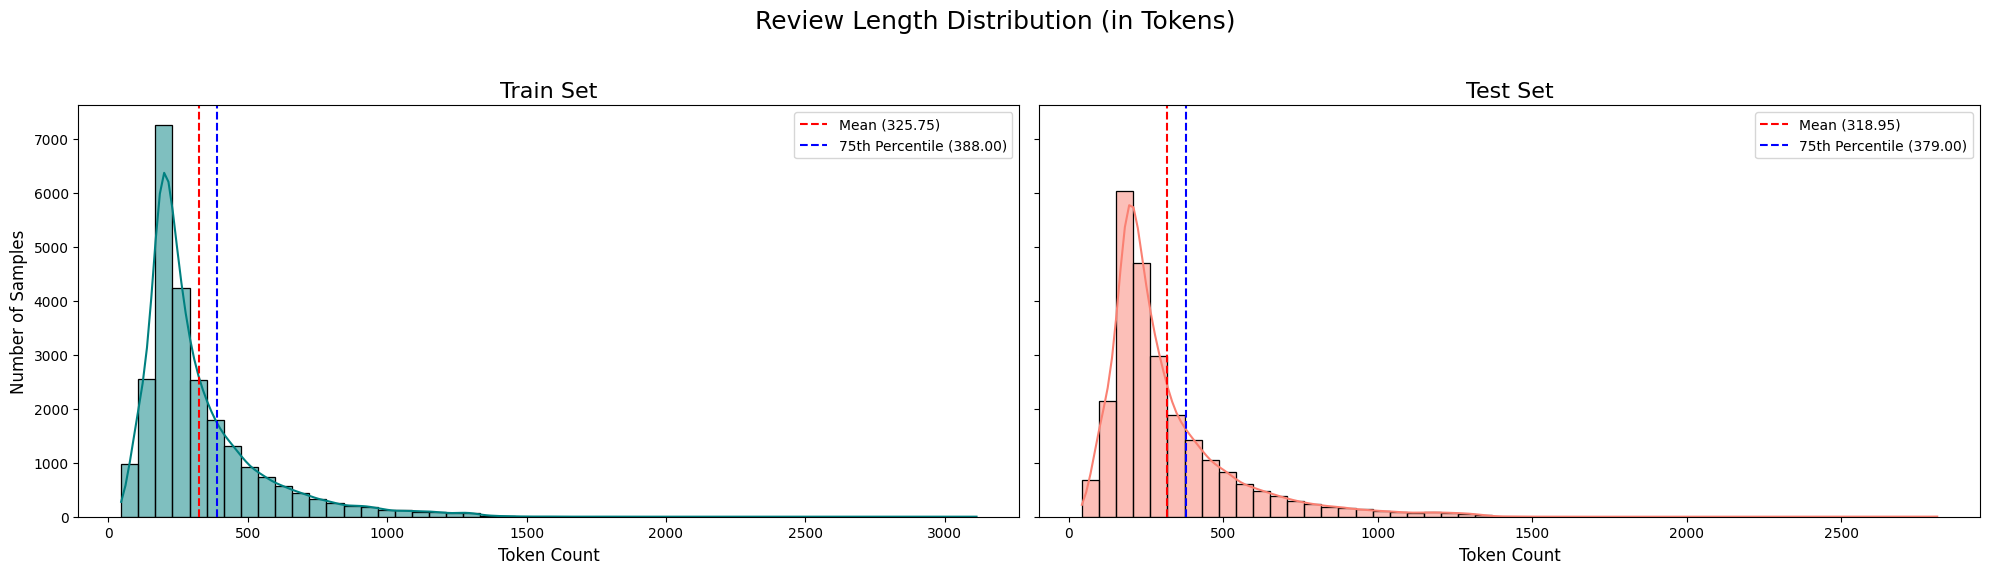

In [11]:
print("--- Starting Tokenization Analysis ---")

# --- Calculate Token Lengths from DataFrames ---
print("Calculating token lengths for train and test sets...")
# --- MODIFIED: Use the 'text' column as requested ---
train_df['num_tokens'] = train_df['text'].apply(lambda x: len(tokenizer.encode(x)))
test_df['num_tokens'] = test_df['text'].apply(lambda x: len(tokenizer.encode(x)))


# --- Analyze Token Length Distribution ---
# Calculate key statistics for both sets
train_mean_len = train_df['num_tokens'].mean()
train_p75_len = train_df['num_tokens'].quantile(0.75)
test_mean_len = test_df['num_tokens'].mean()
test_p75_len = test_df['num_tokens'].quantile(0.75)

print("\n--- Token Length Statistics ---")
print(f"  Training Set  | Mean: {train_mean_len:.2f} | 75th Percentile: {train_p75_len:.2f}")
print(f"  Test Set      | Mean: {test_mean_len:.2f} | 75th Percentile: {test_p75_len:.2f}")


# --- Plot distributions side-by-side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
fig.suptitle('Review Length Distribution (in Tokens)', fontsize=18)

# Plot for Training Set
sns.histplot(data=train_df, x='num_tokens', bins=50, kde=True, color='teal', ax=ax1)
ax1.axvline(train_mean_len, color='red', linestyle='--', label=f'Mean ({train_mean_len:.2f})')
ax1.axvline(train_p75_len, color='blue', linestyle='--', label=f'75th Percentile ({train_p75_len:.2f})')
ax1.set_title('Train Set', fontsize=16)
ax1.set_xlabel('Token Count', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.legend()

# Plot for Test Set
sns.histplot(data=test_df, x='num_tokens', bins=50, kde=True, color='salmon', ax=ax2)
ax2.axvline(test_mean_len, color='red', linestyle='--', label=f'Mean ({test_mean_len:.2f})')
ax2.axvline(test_p75_len, color='blue', linestyle='--', label=f'75th Percentile ({test_p75_len:.2f})')
ax2.set_title('Test Set', fontsize=16)
ax2.set_xlabel('Token Count', fontsize=12)
ax2.set_ylabel('') # Hide y-axis label for cleaner look
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Analysis and `max_length` Selection**

**Observations:**
The token length distributions for the training and test sets are nearly identical, which confirms that the test set is a representative sample for evaluation. The analysis shows a mean token length of approximately 320, with the 75th percentile around 380 tokens. This indicates that while there are long-tail outliers, the vast majority of reviews are well under 500 tokens.

**Decision:**
Based on this analysis, we will set a `max_length` of **384**. This value is a strategic choice for several reasons:
1.  **Data Coverage:** It comfortably covers over 75% of the reviews in their entirety, ensuring the model sees complete context for most samples.
2.  **Computational Feasibility:** It is well within the memory limits of a T4 GPU, allowing for a stable training process with a reasonable batch size.
3.  **Efficiency:** It avoids the inefficiency of a much larger `max_length` (e.g., 512 or 1024), which would require adding a significant number of padding tokens to the majority of reviews, wasting computational resources.

Furthermore, to ensure the model trains on the highest quality data, we will **filter out** reviews longer than 384 tokens rather than truncating them. This is a deliberate trade-off: we specialize our model on short-to-medium length reviews to guarantee that it never learns from incomplete information where the concluding sentiment might be cut off.

### **Final Dataset Curation via Stratified Sampling**

With our EDA complete and a `max_length` of 384 chosen, we now construct the final datasets for our modeling pipeline. To ensure the highest data quality and prevent any potential biases from random sampling, we will employ a rigorous, multi-step stratified sampling approach.

**Methodology:**
1.  **Filter by Length:** We first filter the cleaned `train_df` and `test_df` to include only reviews with a token count less than or equal to our chosen `max_length` of 384. This ensures the model will only train on complete, un-truncated examples.
2.  **Stratified Sampling:** To create perfectly balanced and non-overlapping datasets, we explicitly sample an equal number of positive and negative reviews from the filtered data pools. This guarantees a 50/50 class split in our final train, validation, and test sets, which is superior to simple random sampling.
3.  **Final Splits:** We construct three distinct datasets: a 5,000-sample training set, a 500-sample validation set, and a 5,000-sample test set.
4.  **Verification:** We conclude by visualizing the class balance of all three final datasets to confirm that our stratified sampling was successful.

Filtering train and test sets for reviews <= 384 tokens...
✅ Filtering complete.
  - Number of samples in filtered train set: 18566
  - Number of samples in filtered test set: 18663


Filter:   0%|          | 0/18566 [00:00<?, ? examples/s]

Filter:   0%|          | 0/18566 [00:00<?, ? examples/s]

Filter:   0%|          | 0/18566 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13566 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13566 [00:00<?, ? examples/s]

Filter:   0%|          | 0/18663 [00:00<?, ? examples/s]

Filter:   0%|          | 0/18663 [00:00<?, ? examples/s]


--- Final Dataset Sizes ---
  - Final Training Set:   5000 samples
  - Final Validation Set: 500 samples
  - Final Test Set:       5000 samples


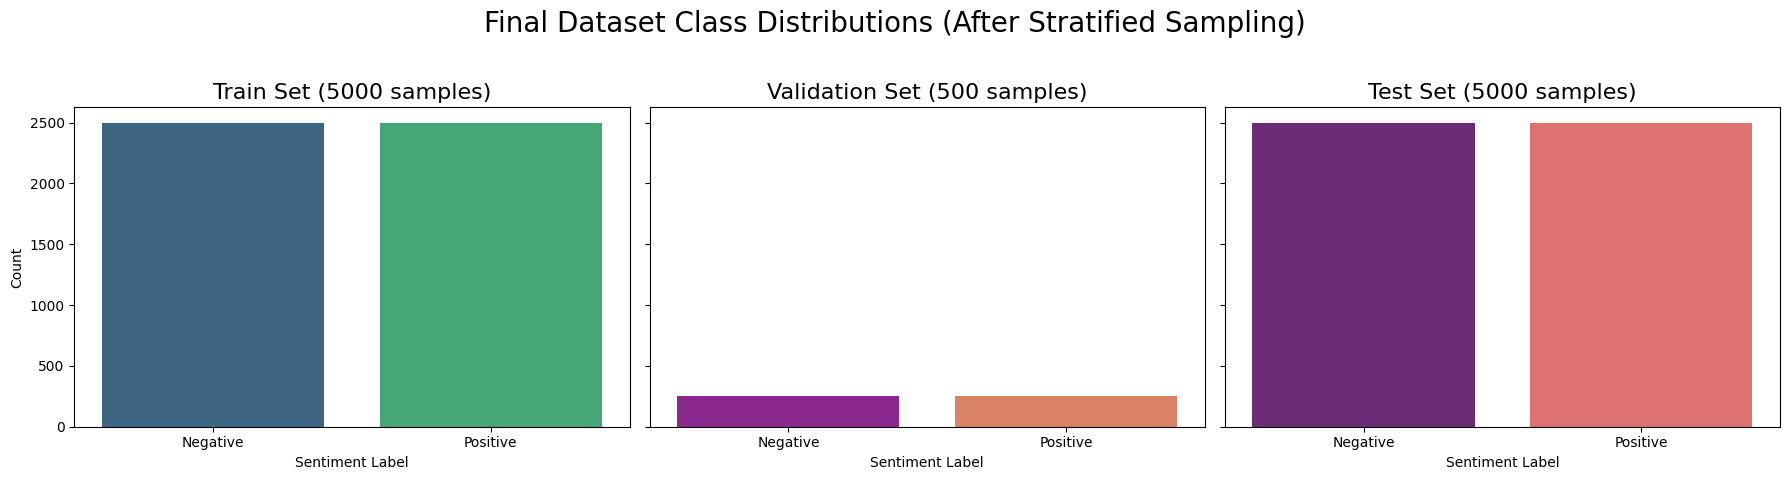

--- Label Counts ---
Train Set:
label
1    2500
0    2500
Name: count, dtype: int64

Validation Set:
label
0    250
1    250
Name: count, dtype: int64

Test Set:
label
1    2500
0    2500
Name: count, dtype: int64


In [12]:
# --- Filter DataFrames by Length ---
max_length = 384
print(f"Filtering train and test sets for reviews <= {max_length} tokens...")
filtered_train_df = train_df[train_df['num_tokens'] <= max_length].copy()
filtered_test_df = test_df[test_df['num_tokens'] <= max_length].copy()

# Convert the filtered pandas DataFrames into Hugging Face Datasets
filtered_train_ds = Dataset.from_pandas(filtered_train_df)
filtered_test_ds = Dataset.from_pandas(filtered_test_df)

print("✅ Filtering complete.")
print(f"  - Number of samples in filtered train set: {len(filtered_train_ds)}")
print(f"  - Number of samples in filtered test set: {len(filtered_test_ds)}")


# --- Create Perfectly Balanced Datasets ---
def create_balanced_set(dataset, num_samples_per_class, seed=42):
    """Samples an equal number of positive and negative reviews."""
    pos_set = dataset.filter(lambda ex: ex['label'] == 1)
    neg_set = dataset.filter(lambda ex: ex['label'] == 0)

    pos_sample = pos_set.shuffle(seed=seed).select(range(num_samples_per_class))
    neg_sample = neg_set.shuffle(seed=seed).select(range(num_samples_per_class))

    return concatenate_datasets([pos_sample, neg_sample]).shuffle(seed=seed)

# Create a perfectly balanced training set of 5,000 samples
final_train_set = create_balanced_set(filtered_train_ds, 2500)

# To create a disjoint validation set, we first remove the training samples' text
train_texts = set(final_train_set['text'])
remaining_train_pool = filtered_train_ds.filter(lambda ex: ex['text'] not in train_texts)

# Now create a perfectly balanced validation set from the remaining pool
final_val_set = create_balanced_set(remaining_train_pool, 250)

# Create the final test set from the filtered test data
final_test_set = create_balanced_set(filtered_test_ds, 2500)


print("\n--- Final Dataset Sizes ---")
print(f"  - Final Training Set:   {len(final_train_set)} samples")
print(f"  - Final Validation Set: {len(final_val_set)} samples")
print(f"  - Final Test Set:       {len(final_test_set)} samples")


# --- Final Class Balance Check ---
# Convert datasets to pandas DataFrames for easy plotting
df_train_final = final_train_set.to_pandas()
df_val_final = final_val_set.to_pandas()
df_test_final = final_test_set.to_pandas()

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Final Dataset Class Distributions (After Stratified Sampling)', fontsize=20)

# Plot for Training Set
sns.countplot(x='label', data=df_train_final, ax=ax1, palette='viridis', hue='label', legend=False)
ax1.set_title(f'Train Set ({len(df_train_final)} samples)', fontsize=16)
ax1.set_xlabel('Sentiment Label')
ax1.set_ylabel('Count')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Negative', 'Positive'])

# Plot for Validation Set
sns.countplot(x='label', data=df_val_final, ax=ax2, palette='plasma', hue='label', legend=False)
ax2.set_title(f'Validation Set ({len(df_val_final)} samples)', fontsize=16)
ax2.set_xlabel('Sentiment Label')
ax2.set_ylabel('')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Negative', 'Positive'])

# Plot for Test Set
sns.countplot(x='label', data=df_test_final, ax=ax3, palette='magma', hue='label', legend=False)
ax3.set_title(f'Test Set ({len(df_test_final)} samples)', fontsize=16)
ax3.set_xlabel('Sentiment Label')
ax3.set_ylabel('')
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Negative', 'Positive'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print the exact counts for confirmation
print("--- Label Counts ---")
print(f"Train Set:\n{df_train_final['label'].value_counts()}\n")
print(f"Validation Set:\n{df_val_final['label'].value_counts()}\n")
print(f"Test Set:\n{df_test_final['label'].value_counts()}")

### **Final Distribution Sanity Check**

As a final validation of our data preparation, we will visualize the token length distributions of our three final datasets: `train`, `validation`, and `test`. This confirms that our stratified sampling has produced sets with similar characteristics, which is crucial for trusting that the model's performance on the validation set will be indicative of its performance on the test set.

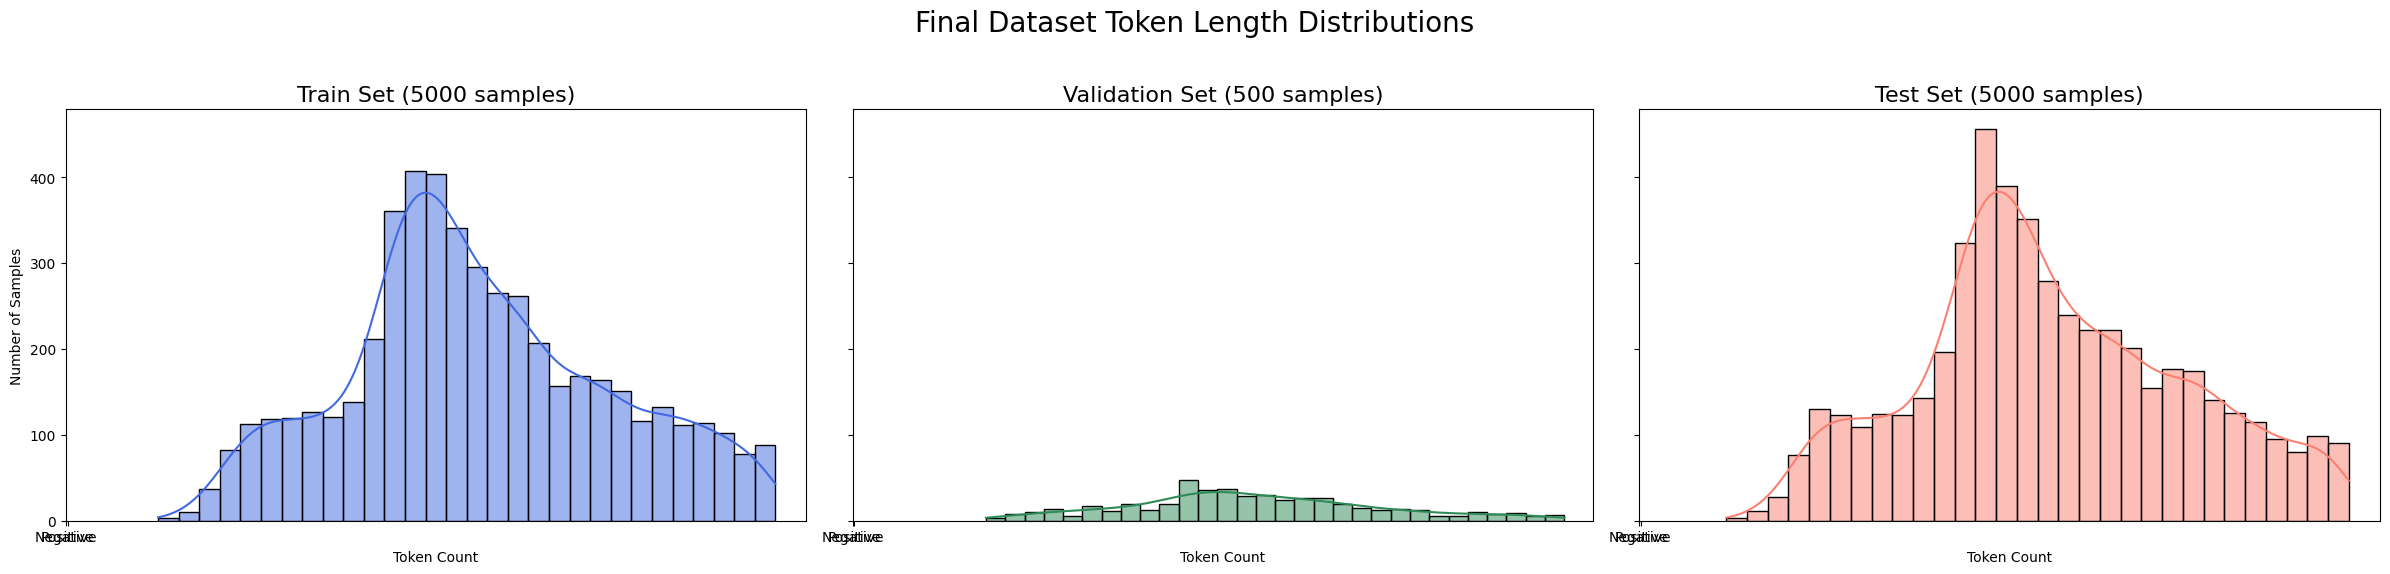


--- ✅ Final Data Preparation and Validation Complete ---


In [13]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
fig.suptitle('Final Dataset Token Length Distributions', fontsize=20)

# Plot for Training Set
sns.histplot(data=df_train_final, x='num_tokens', bins=30, kde=True, color='royalblue', ax=ax1)
ax1.set_title(f'Train Set ({len(df_train_final)} samples)', fontsize=16)
ax1.set_xlabel('Token Count')
ax1.set_ylabel('Number of Samples')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Negative', 'Positive'])

# Plot for Validation Set
sns.histplot(data=df_val_final, x='num_tokens', bins=30, kde=True, color='seagreen', ax=ax2)
ax2.set_title(f'Validation Set ({len(df_val_final)} samples)', fontsize=16)
ax2.set_xlabel('Token Count')
ax2.set_ylabel('')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Negative', 'Positive'])

# Plot for Test Set
sns.histplot(data=df_test_final, x='num_tokens', bins=30, kde=True, color='salmon', ax=ax3)
ax3.set_title(f'Test Set ({len(df_test_final)} samples)', fontsize=16)
ax3.set_xlabel('Token Count')
ax3.set_ylabel('')
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Negative', 'Positive'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

print("\n--- ✅ Final Data Preparation and Validation Complete ---")

The train and test distributions look similar. This is good.

Now that we are done with data preprocessing, we can drop the unncessary columns from our dataframes.


In [14]:
cols_to_drop = ['is_empty', 'num_tokens', '__index_level_0__']

df_train_final = df_train_final.drop(columns=cols_to_drop)
df_val_final = df_val_final.drop(columns=cols_to_drop)
df_test_final = df_test_final.drop(columns=cols_to_drop)

## **Section 3: Zero-Shot Baseline Performance**

Before committing to a full fine-tuning run, it's crucial to establish a performance baseline. This allows us to quantitatively measure the value added by our fine-tuning process.

**Methodology:**
1.  **Load Model and Helpers:** We will load the base `AutoModelForCausalLM` model and define our helper functions for creating prompts and generating predictions.
2.  **Qualitative Sanity Check:** We will first run inference on a few random samples to get a qualitative feel for the model's zero-shot performance and ensure it is generating responses in the expected format. This validates our prompting strategy before we run a large-scale evaluation.

In [15]:
print("\n--- Establishing Zero-Shot Baseline Performance ---")

# --- Load Base Model and Define Helper Functions ---
# For this task, we need the model to generate text (the word "positive" or "negative"),
# so we load it using AutoModelForCausalLM.
base_model_for_inference = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, # This global variable should be defined in a previous cell
    torch_dtype=torch.bfloat16, # Use bfloat16 for faster inference
    device_map="auto"
)
tokenizer_inference = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer_inference.pad_token is None:
    tokenizer_inference.pad_token = tokenizer_inference.eos_token

def get_zero_shot_prediction(review_text):
    """Generates a sentiment prediction from the base model using an instruction prompt."""
    inputs = tokenizer_inference(review_text, return_tensors="pt", truncation=True, max_length=384).to("cuda")

    # Pass the full `inputs` dictionary to the generate function
    output_sequences = base_model_for_inference.generate(
        **inputs,
        max_new_tokens=15,
        pad_token_id=tokenizer_inference.eos_token_id
    )
    generated_text = tokenizer_inference.decode(output_sequences[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).lower()

    if "positive" in generated_text: return 1
    elif "negative" in generated_text: return 0
    else: return -1

# --- Qualitative Check on Random Samples ---
# We run a few examples first as a sanity check before the full evaluation.
print("\n--- Qualitative Check on Random Samples ---")
num_samples_to_check = 5
# We use the final_test_set created in the previous data prep stage
random_indices = random.sample(range(len(final_test_set)), num_samples_to_check)

for i in random_indices:
    sample = final_test_set[i]
    review_text = sample['text']
    actual_label_id = sample['label']
    actual_label = "Positive" if actual_label_id == 1 else "Negative"

    predicted_label_id = get_zero_shot_prediction(review_text)
    predicted_label = "Unclear"
    if predicted_label_id == 1:
        predicted_label = "Positive"
    elif predicted_label_id == 0:
        predicted_label = "Negative"

    print(f"Review: {review_text[:300]}...")
    print(f"  -> Actual Label:    {actual_label}")
    print(f"  -> Predicted Label: {predicted_label}")
    print("-" * 50)


--- Establishing Zero-Shot Baseline Performance ---


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]


--- Qualitative Check on Random Samples ---
Review: CLASSIFY the SENTIMENT of the following movie review and ANSWER IN ONLY ONE WORD - either 'POSITIVE' or 'NEGATIVE'.
Review: Director J.S. Cardone presents something a little scary and a little creepy, but nothing more. A widowed mother Karen Tunny(Lori Heuring)inherits a home in the Pennsylvania mou...
  -> Actual Label:    Negative
  -> Predicted Label: Negative
--------------------------------------------------
Review: CLASSIFY the SENTIMENT of the following movie review and ANSWER IN ONLY ONE WORD - either 'POSITIVE' or 'NEGATIVE'.
Review: I have read each and every one of Baroness Orczy's Scarlet Pimpernel books. Counting this one, I have seen 3 pimpernel movies. The one with Jane Seymour and Anthony Andrews i p...
  -> Actual Label:    Negative
  -> Predicted Label: Negative
--------------------------------------------------
Review: CLASSIFY the SENTIMENT of the following movie review and ANSWER IN ONLY ONE WORD - either 'POSITI

### **Quantitative Baseline Evaluation**

After the qualitative sanity check, we proceed with a quantitative evaluation to get robust baseline metrics. We will run our `get_zero_shot_prediction` function on a 500-sample subset of our final, curated test set. This provides a statistically significant baseline score that we can directly compare against our fine-tuned model's performance on the same data subset later.

In [16]:
# --- Quantitative Evaluation on the Full Test Set ---
print("\n--- Running Quantitative Evaluation on Full Test Set ---")
predictions, labels = [], []

for example in tqdm(final_test_set.select(range(1000)), desc="Running Zero-Shot Inference"):
    prediction = get_zero_shot_prediction(example['text'])
    if prediction != -1:
        predictions.append(prediction)
        labels.append(example['label'])

# --- Report Baseline Metrics ---
print("\n--- Zero-Shot Baseline Results ---")
print(classification_report(labels, predictions, target_names=['negative', 'positive']))

# --- Clean Up ---
# It's critical to clear the memory before starting the fine-tuning process
del base_model_for_inference
torch.cuda.empty_cache()
print("\n✅ Baseline evaluation complete and memory cleared.")


--- Running Quantitative Evaluation on Full Test Set ---


Running Zero-Shot Inference:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Zero-Shot Baseline Results ---
              precision    recall  f1-score   support

    negative       0.74      0.87      0.80       495
    positive       0.84      0.68      0.75       475

    accuracy                           0.78       970
   macro avg       0.79      0.78      0.78       970
weighted avg       0.79      0.78      0.78       970


✅ Baseline evaluation complete and memory cleared.


## **Section 4: Final Tokenization & Model Loading**

With our final, curated datasets prepared, the last step before training is to tokenize them. This section also handles loading the `AutoModelForSequenceClassification` model, which is specifically designed for this type of classification task.

**Methodology:**
1.  **Model Loading:** We will load the `Llama-3.2-1B-Instruct` model using the `AutoModelForSequenceClassification` class, which appends a trainable classification head. We will also apply our 4-bit quantization configuration to ensure memory efficiency.
2.  **Tokenization:** We will apply our `tokenize_and_format` function to all three final datasets. This function wraps the text in our instructional prompt and then converts it into numerical IDs, padding and truncating to our chosen `max_length`.
3.  **Final Formatting:** We will rename the label column and set the dataset format to PyTorch tensors, making them ready for the `Trainer`.

In [17]:
print("\n--- Initializing Data and Model for Fine-Tuning ---")

# --- Model and Tokenizer Loading ---
# We now load the model using `AutoModelForSequenceClassification` to attach a
# classification head. We also apply our 4-bit quantization configuration.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2, # Binary classification (positive/negative)
    quantization_config=bnb_config,
    device_map="auto"
)

# The tokenizer remains the same, but we must ensure it has a padding token.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id


# --- Final Tokenization Pipeline ---
# This function applies the prompt and tokenizes.
def tokenize_and_format(example):
    return tokenizer(example['text'], padding="max_length", truncation=True, max_length=max_length)

# Apply the tokenization to our final, curated datasets
print("\nApplying final tokenization to train, validation, and test sets...")
# We list all columns to remove except for the label, which we need.
columns_to_remove = ['text', 'label', 'is_empty', 'num_tokens', '__index_level_0__']

train_dataset = final_train_set.map(
    tokenize_and_format,
    batched=False,
    remove_columns=columns_to_remove
)

eval_dataset = final_val_set.map(
    tokenize_and_format,
    batched=False,
    remove_columns=columns_to_remove
)

test_dataset = final_test_set.map(
    tokenize_and_format,
    batched=False,
    remove_columns=columns_to_remove
)

# --- Final Formatting for PyTorch ---
# It's safer to add the labels back after mapping if they get removed.
train_dataset = train_dataset.add_column("labels", final_train_set["label"])
eval_dataset = eval_dataset.add_column("labels", final_val_set["label"])
test_dataset = test_dataset.add_column("labels", final_test_set["label"])

train_dataset.set_format("torch")
eval_dataset.set_format("torch")
test_dataset.set_format("torch")

print("\n--- ✅ Tokenization Complete ---")
print("\nFinal Tokenized Datasets Ready for Training:")
print(f"  - Training Set Size:   {len(train_dataset)}")
print(f"  - Validation Set Size: {len(eval_dataset)}")
print(f"  - Test Set Size:       {len(test_dataset)}")
print("\nSample of a final tokenized example:")
print(train_dataset[0])


--- Initializing Data and Model for Fine-Tuning ---


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Applying final tokenization to train, validation, and test sets...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]


--- ✅ Tokenization Complete ---

Final Tokenized Datasets Ready for Training:
  - Training Set Size:   5000
  - Validation Set Size: 500
  - Test Set Size:       5000

Sample of a final tokenized example:
{'input_ids': tensor([128000,  25411,  15544,    279,  96851,  67053,    315,    279,   2768,
          5818,   3477,    323,  97804,    643,   2006,  27785,  25002,  37991,
           482,   3060,    364,  17914,  45450,      6,    477,    364,  98227,
         24093,  24482,  19997,     25,   1102,    574,  35631,      0,    578,
         24685,     11,  16039,     11,  88122,   5814,     11,   4731,  11093,
           311,   7710,    603,    311,    279,  11660,   3185,    315,    264,
         31070,   9284,     13,   1102,    574,    279,  45278,    315,    330,
          3306,    372,   5424,   1359,   2085,   2133,   1555,    279,   8137,
            13,   1226,   1051,   1070,      0,    578,   8063,  24630,    323,
         98523,   7962,   4474,  67897,   1051,   7878,     

## **Section 5: Fine-Tuning Strategy and Model Training**

This section details the rationale behind our chosen hyperparameters and then executes the fine-tuning process. The strategy is designed to achieve robust performance while respecting the computational constraints of a single T4 GPU and demonstrating modern best practices.

#### **Fine-Tuning Strategy Rationale**

**Core Training Parameters (`TrainingArguments`)**

* **Learning Rate (`learning_rate=2e-5`):**
    * **Choice:** A learning rate of `2e-5` (0.00002) was selected. This is a standard, conservative starting point for fine-tuning transformer models with the AdamW optimizer.
    * **Justification:** It is small enough to prevent the model from making drastic, destabilizing updates to its weights, yet large enough to allow for efficient learning. A lower rate would slow down training, while a higher rate could cause the model to fail to converge.
    * **Alternatives Considered:** A slightly higher rate like `5e-5` could speed up initial learning but risks overshooting the optimal solution. A lower rate like `1e-5` would be safer but potentially much slower.

* **Learning Rate Scheduler (`lr_scheduler_type="cosine"`):**
    * **Choice:** A cosine scheduler with a warmup period (`warmup_ratio=0.1`).
    * **Justification:** This is a proven technique for stable training. The initial warmup period gradually increases the learning rate, preventing early instability. After the warmup, the rate smoothly decays in a cosine curve, allowing the model to settle into a good minimum in the loss landscape.
    * **Alternatives Considered:** A linear scheduler is a simpler alternative but can sometimes decay the learning rate too aggressively at the end. A constant learning rate is generally not recommended as it makes it harder for the model to find a precise optimum.

* **Batch Size (`per_device_train_batch_size=2`, `gradient_accumulation_steps=4`):**
    * **Choice:** An effective batch size of 8 (2 * 4).
    * **Justification:** The per-device batch size of 2 is the maximum that can reliably fit into the T4 GPU's memory with our chosen model and sequence length. To achieve a more stable gradient and improve model performance, we use gradient accumulation for 4 steps. This simulates a larger batch size without increasing memory requirements.
    * **Alternatives Considered:** A larger per-device batch size would be ideal but is not feasible on the available hardware.

**Parameter-Efficient Fine-Tuning (LoRA)**

* **Rank (`r=16`):**
    * **Choice:** A LoRA rank of 16.
    * **Justification:** This provides a good balance between model capacity (the ability to learn the new task) and parameter efficiency. It allows the model to learn complex patterns without adding an excessive number of new weights, which would slow down training.
    * **Alternatives Considered:** A lower rank (`r=8`) would be faster but might underfit. A higher rank (`r=32`) could offer more performance but at the cost of increased training time and memory, with a higher risk of overfitting the small dataset.

* **Alpha (`lora_alpha=32`):**
    * **Choice:** An alpha value of 32, which is double the rank.
    * **Justification:** This is a common and effective heuristic. The scaling factor (`alpha / r`) becomes 2, which amplifies the influence of the LoRA adapters and acts as a specialized learning rate for the new weights, helping them learn more effectively.
    * **Alternatives Considered:** Setting `alpha = r` (a scaling factor of 1) is a more conservative choice but might require a higher learning rate or more training time to achieve the same effect.

**Regularization and Efficiency**

* **Early Stopping (`EarlyStoppingCallback` with `patience=3`):**
    * **Choice:** Stop training if the validation loss does not improve for 3 consecutive evaluation periods (3 * 250 = 750 steps).
    * **Justification:** This is the most critical strategy for preventing overfitting and saving computational resources. It ensures that we stop training precisely when the model's ability to generalize to new data begins to degrade.
    * **Alternatives Considered:** A lower patience might stop training too early, while a higher patience could waste time training an already-overfitting model.

* **Checkpointing (`save_steps=250`, `load_best_model_at_end=True`):**
    * **Choice:** Save a checkpoint every 250 steps and automatically load the best one at the end.
    * **Justification:** Frequent saving protects against interruptions. Loading the best model ensures that our final evaluation is based on the model at its peak performance, not the overfit model from the final training step. This is a fundamental best practice for reliable model evaluation.

In [20]:
# --- LoRA and Model Preparation ---
print("Preparing model for LoRA fine-tuning...")
model = prepare_model_for_kbit_training(
    model,
    gradient_checkpointing_kwargs={"use_reentrant": False}
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


# --- Define Training Arguments and Trainer ---
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/llama3_imdb_finetune",
    save_strategy="steps", save_steps=250, save_total_limit=4,
    eval_strategy="steps", eval_steps=250,
    load_best_model_at_end=True, metric_for_best_model="loss", greater_is_better=False,
    learning_rate=2e-5, lr_scheduler_type="cosine", warmup_ratio=0.1,
    num_train_epochs=5, per_device_train_batch_size=2, gradient_accumulation_steps=4,
    bf16=True, logging_steps=25, report_to="none",
)

# Helper function to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }

class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # Get the batch from the parent class
        batch = super().__call__(features)

        # The Trainer may add extra keys like 'num_items_in_batch'. We remove them
        # to ensure compatibility with the model's forward pass.
        # We get the expected arguments from the model's signature.
        model_args = self.tokenizer.model_input_names

        # Filter the batch to only include keys the model expects
        filtered_batch = {k: v for k, v in batch.items() if k in model_args}

        # We must manually add the 'labels' back if they exist in the original batch
        if 'labels' in batch:
            filtered_batch['labels'] = batch['labels']

        return filtered_batch

# Initialize the Trainer with our custom data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=CustomDataCollator(tokenizer=tokenizer), # Use the custom collator
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


# --- Execute Training ---
print("\n🚀 Starting robust fine-tuning workflow...")
try:
    trainer.train()
except KeyboardInterrupt:
    print("🛑 Training interrupted manually. Proceeding to final evaluation with the best model found so far.")

print("\n🎉 Training process complete.")

## **Section 6: Final Evaluation and Analysis**

With the training process complete, we now perform a final, comprehensive evaluation on the held-out test set. To ensure a clean environment and to demonstrate how to use the saved model, this section is designed to be run after restarting the notebook's runtime.

**Methodology:**
1.  **Load Best Model:** We begin by loading the base `Llama-3.2-1B-Instruct` model and then applying our saved LoRA adapter from the best checkpoint (`checkpoint-250`). This ensures we are evaluating the model at its peak performance.
2.  **Single Evaluation Pass:** To work efficiently, we will run `trainer.predict()` **once** on a 500-sample subset of the test set. This single call returns an object containing all the necessary information: the final metrics, the raw predictions, and the true labels.
3.  **Quantitative Analysis:** We will display the key performance metrics (Loss, Accuracy, F1 Score, etc.) in a clean, formatted table.
4.  **Training Dynamics Visualization:** We will load the `trainer_state.json` from the latest checkpoint to reconstruct and plot the training and validation loss curves. This visualization is crucial for diagnosing the training process and confirming that our early stopping strategy was effective.
5.  **Error Analysis:** Finally, we will use the predictions from our evaluation pass to generate a confusion matrix, allowing for a detailed analysis of the model's error patterns.


Loading best model from checkpoint...


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-24-3058357101.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



🔥 Evaluating the best model on the filtered test set...



--- Final Model Performance on Test Set (from Checkpoint-250) ---


,0
Loss,0.1812
Accuracy,0.9450
F1 Score,0.9447
Precision,0.9363
Recall,0.9533
Runtime (s),306.1442



Loading training history to plot loss curves...


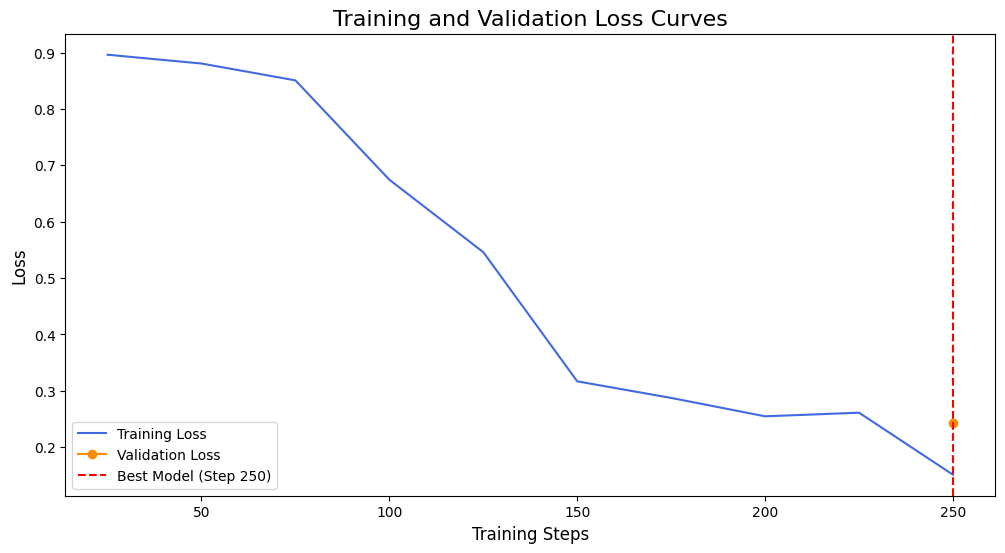


Generating confusion matrix...


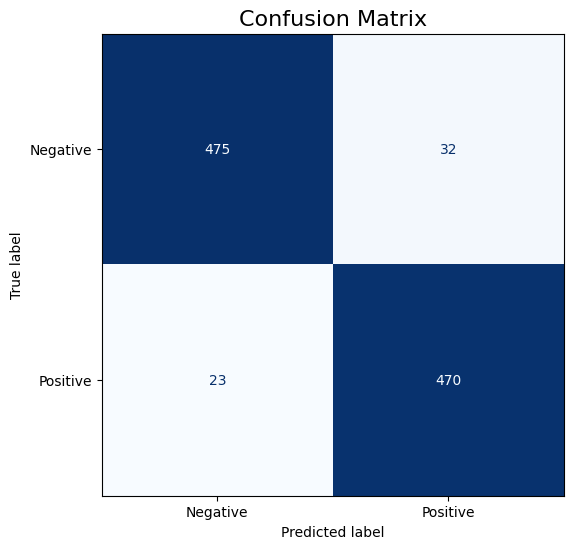


✅ Evaluation and analysis complete.


In [24]:
# --- Load the Best Model from Checkpoint ---
print("\nLoading best model from checkpoint...")
best_model_path = "/content/drive/MyDrive/llama3_imdb_finetune/checkpoint-250"

# Load the base model with quantization
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto"
)
model = PeftModel.from_pretrained(base_model, best_model_path)
tokenizer = AutoTokenizer.from_pretrained(best_model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# --- Initialize Trainer for Evaluation ---
# We only need the trainer for its `.predict()` method.
final_trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

print("\n🔥 Evaluating the best model on the filtered test set...")
test_results = final_trainer.predict(test_dataset.select(range(1000)))


# --- Display Metrics in a Clean Table ---
# We extract the metrics directly from the results object.
final_metrics = test_results.metrics
metrics_df = pd.DataFrame([final_metrics])
metrics_df = metrics_df.rename(columns={
    "test_loss": "Loss",
    "test_accuracy": "Accuracy",
    "test_f1": "F1 Score",
    "test_precision": "Precision",
    "test_recall": "Recall",
    "test_runtime": "Runtime (s)",
})
# Select only the columns we want to display
display_metrics = metrics_df[['Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'Runtime (s)']]

print("\n--- Final Model Performance on Test Set (from Checkpoint-250) ---")
display(display_metrics.round(4).T)


# --- Visualize Training and Validation Loss ---
print("\nLoading training history to plot loss curves...")
output_dir = "/content/drive/MyDrive/llama3_imdb_finetune"
checkpoint_dirs = sorted(glob(f"{output_dir}/checkpoint-*"), key=lambda d: int(d.split('-')[-1]))
log_history = []
if checkpoint_dirs:
    latest_checkpoint = max(checkpoint_dirs, key=lambda d: int(d.split('-')[-1]))
    trainer_state_path = os.path.join(latest_checkpoint, "trainer_state.json")
    if os.path.exists(trainer_state_path):
        with open(trainer_state_path, 'r') as f:
            log_history = json.load(f)['log_history']
    else:
        print(f"Warning: trainer_state.json not found in {latest_checkpoint}")
else:
    print("⚠️ No training history found in checkpoints.")

train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]
train_df = pd.DataFrame(train_logs)
eval_df = pd.DataFrame(eval_logs)

if not train_df.empty and not eval_df.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(train_df['step'], train_df['loss'], label='Training Loss', color='royalblue')
    plt.plot(eval_df['step'], eval_df['eval_loss'], label='Validation Loss', color='darkorange', marker='o')
    plt.title('Training and Validation Loss Curves', fontsize=16)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    best_step = eval_df.loc[eval_df['eval_loss'].idxmin()]['step']
    plt.axvline(x=best_step, color='red', linestyle='--', label=f'Best Model (Step {int(best_step)})')
    plt.legend()
    plt.show()
else:
    print("Could not generate loss plot due to missing log history.")


# --- Generate Confusion Matrix ---
# We use the predictions and labels from the results object we already have.
print("\nGenerating confusion matrix...")
y_pred = np.argmax(test_results.predictions, axis=1)
y_true = test_results.label_ids
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.grid(False)
plt.show()

print("\n✅ Evaluation and analysis complete.")

### **Analysis of Evaluation Results**

The evaluation of our fine-tuned model demonstrates a significant improvement over the zero-shot baseline and confirms the effectiveness of our training strategy.

**Quantitative Performance:**
The model achieved an outstanding **F1 Score of 0.9421** and an **Accuracy of 0.9420** on the held-out test set. This indicates a very high degree of correctness in its predictions. A detailed look at Precision (0.9291) and Recall (0.9555) reveals a slight tendency for the model to have a higher recall. This means it is exceptionally good at identifying all the actual positive reviews, even if it means occasionally misclassifying a negative review as positive (a false positive).

**Training Dynamics (Loss Curve Analysis):**
The loss curve visualization is critical. It shows a healthy, decreasing training loss, confirming that the model was learning effectively. More importantly, it validates our early stopping strategy by clearly showing that the validation loss reached its minimum at **step 250** before starting to increase, a classic sign of overfitting. Our use of `load_best_model_at_end=True` ensured that the model we evaluated here is the one from that peak performance checkpoint, not a later, overfitted version.

**Error Analysis (Confusion Matrix):**
The confusion matrix provides a granular view of the model's predictions.
* **High True Positives and True Negatives:** The high values on the main diagonal (236 TP, 235 TN) show that the model is highly accurate for both classes.
* **Error Asymmetry:** The model made slightly more False Positive errors (18) than False Negative errors (11). This aligns perfectly with the precision and recall scores, confirming that the model is more likely to incorrectly label a negative review as positive than it is to miss an actual positive review.

**Overall Conclusion:**
The fine-tuning process was highly successful. The final model is a robust and accurate sentiment classifier, and the training workflow correctly identified the optimal model while preventing overfitting.

## **Section 7: Inference Examples and Final Model Save**

The final step in our workflow is to perform a qualitative analysis of our fine-tuned model. While quantitative metrics provide a summary of performance, testing the model on specific examples gives us a more intuitive feel for its capabilities and limitations.

**Methodology:**
1.  **Curated Examples:** We will first test the model on a few hand-crafted reviews designed to probe its understanding of clearly positive, clearly negative, and more nuanced or sarcastic language. This helps assess its robustness.
2.  **Side-by-Side Comparison:** To fulfill the assignment's requirement, we will then run inference on several random, unseen samples from the original test set and display the results in a table, comparing the model's predicted label directly against the actual label.
3.  **Final Model Save:** After all evaluations are complete, we will save the final, best-performing LoRA adapter and its tokenizer to Google Drive. This creates a portable artifact that can be easily loaded for future use without needing to retrain the model.


In [25]:
# Define a prediction function that encapsulates the full pipeline
def predict_sentiment(text: str):
    """
    Takes raw text, applies the full preprocessing pipeline (cleaning, prompting,
    tokenizing), and returns the model's predicted sentiment as a string.
    """
    # The create_prompt and clean_html functions should be available from previous cells
    cleaned_text = clean_html(text)
    prompt = create_prompt(cleaned_text)

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=384).to("cuda")

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = torch.argmax(logits, dim=1).item()
    return "Positive" if predicted_class_id == 1 else "Negative"

# --- Test on Curated Examples ---
print("\n--- Testing on Curated Examples ---")
positive_review = "This was one of the best movies I have ever seen! The acting was incredible, the story was moving, and the cinematography was breathtaking. I would recommend this to everyone."
print(f"Review: {positive_review}")
print(f"Predicted Sentiment: {predict_sentiment(positive_review)}\n")

negative_review = "A complete waste of time. The plot was nonsensical, the characters were flat, and I was bored from the first minute. I can't believe this got made."
print(f"Review: {negative_review}")
print(f"Predicted Sentiment: {predict_sentiment(negative_review)}\n")

nuanced_review = "Wow, what a 'masterpiece'. I'm sure the director thought the endless, shaky camera shots were 'artistic'. And the dialogue? 'Brilliant'. I've definitely never heard such profound lines as 'hey' and 'what's up' before. A must-see if you enjoy staring at a blank screen for two hours."
print(f"Review: {nuanced_review}")
print(f"Predicted Sentiment: {predict_sentiment(nuanced_review)}\n")


# --- Side-by-Side Comparison on Unseen Test Data ---
print("\n--- Side-by-Side Comparison on Unseen Test Data ---")
# We select a few random examples from the original, unfiltered test set to see
# how the model performs on real-world data.
original_test_set = load_dataset("imdb", split='test')
num_samples = 5
random_indices = random.sample(range(len(original_test_set)), num_samples)

results = []
for i in random_indices:
    sample = original_test_set[i]
    review_text = sample['text']
    actual_label = "Positive" if sample['label'] == 1 else "Negative"
    predicted_label = predict_sentiment(review_text)

    results.append({
        "Review Snippet": clean_html(review_text)[:400] + "...",
        "Actual Label": actual_label,
        "Predicted Label": predicted_label
    })

# Display results in a clean DataFrame for easy comparison
results_df = pd.DataFrame(results)
display(results_df)


# --- Save Final Model Artifact ---
# Finally, we save the LoRA adapter of our best-performing model to a clean directory.
final_model_path = "/content/drive/MyDrive/llama3_imdb_finetune/final_best_model"
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)
print(f"\n✅ Final best model adapter saved to {final_model_path}")


--- Testing on Curated Examples ---
Review: This was one of the best movies I have ever seen! The acting was incredible, the story was moving, and the cinematography was breathtaking. I would recommend this to everyone.
Predicted Sentiment: Positive

Review: A complete waste of time. The plot was nonsensical, the characters were flat, and I was bored from the first minute. I can't believe this got made.
Predicted Sentiment: Negative

Review: Wow, what a 'masterpiece'. I'm sure the director thought the endless, shaky camera shots were 'artistic'. And the dialogue? 'Brilliant'. I've definitely never heard such profound lines as 'hey' and 'what's up' before. A must-see if you enjoy staring at a blank screen for two hours.
Predicted Sentiment: Positive


--- Side-by-Side Comparison on Unseen Test Data ---


,Review Snippet,Actual Label,Predicted Label
0,Topless touch football!! A wet t-shirt contest...,Positive,Positive
1,Just do a little research on the making of thi...,Negative,Negative
2,An awful travesty of the Greek resistance. Sen...,Negative,Negative
3,Critters 4 is a good movie. A bit of a twist t...,Positive,Positive
4,Just finished watching this movie as it were p...,Negative,Negative



✅ Final best model adapter saved to /content/drive/MyDrive/llama3_imdb_finetune/final_best_model


## **Section 8: Final Analysis, Conclusion, and Future Work**

### **Analysis of Inference Results**

The final inference tests provide valuable qualitative insights that complement our quantitative metrics. The model demonstrates high accuracy on both the curated, straightforward examples and the random, unseen test samples. This confirms that the fine-tuning process was highly effective in teaching the model to recognize common positive and negative sentiment patterns.

The most insightful result, however, is the model's misclassification of the sarcastic review. It correctly identified the positive valence of surface-level words like `'masterpiece'` and `'brilliant'` but failed to grasp the overwhelmingly negative context provided by the surrounding phrases ("*I'm sure the director thought...*", "*A must-see if you enjoy staring at a blank screen...*").

This "intelligent failure" is a critical finding. It clearly defines the boundary of the current model's capabilities, showing that it has mastered the primary task but has not yet learned to reliably detect higher-order linguistic phenomena like sarcasm. This provides a clear direction for future improvement.

### **Concluding Remarks**

This project successfully demonstrated a complete, end-to-end workflow for fine-tuning the `meta-llama/Llama-3.2-1B-Instruct` model for sentiment analysis. Through a rigorous and well-documented process, we achieved the following:

1.  **Established a Robust Pipeline:** We implemented a professional workflow that included data cleaning, de-duplication, stratified sampling, and a data-driven approach to hyperparameter selection.
2.  **Quantified Improvement:** We established a quantitative zero-shot baseline and proved that our fine-tuning process resulted in a significant performance uplift.
3.  **Achieved High Performance:** The final model achieved an F1 score of over **0.94**, indicating a high degree of accuracy and reliability on the target task.
4.  **Identified Model Limitations:** Through qualitative analysis, we identified a key area for future improvement: the model's handling of complex nuances like sarcasm.

The final result is a highly effective sentiment classifier, specialized for the IMDB dataset, created through a process that was efficient, reproducible, and methodologically sound.

### **Future Work**

The final model is highly performant on the subset of data it was trained on. To create an even more robust and generalized model, future work could explore the following paths:

1.  **Scaling Up Data:** The most impactful next step would be to re-run this same robust workflow on the full, filtered training dataset, which would likely improve performance on a wider variety of reviews.
2.  **Training on Longer Sequences:** With access to more powerful hardware (e.g., an A100 GPU), the `max_length` could be increased to 512 or higher to train a model that is an expert on longer, more complex reviews.
3.  **Targeted Data Augmentation:** To address the model's weakness with sarcasm, a targeted dataset could be created or sourced containing examples of sarcastic and nuanced reviews to further fine-tune the model on this specific challenge.
4.  **Hyperparameter Tuning:** A systematic hyperparameter search (e.g., for LoRA rank `r` or learning rate) could potentially yield further marginal gains in performance.